# Base Settings

In [86]:
import os
from datetime import datetime
import pathlib

import json

import PIL
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from keras import layers
from keras import Sequential

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

In [2]:
# dataset_dir = pathlib.Path('/kaggle/input/architectural-styles-dataset/architectural-styles-dataset')
# dataset_dir = pathlib.Path('/kaggle/input/architectural-styles-dataset/g-images-dataset')
# dataset_dir = pathlib.Path('/kaggle/input/architecures-style-small')
dataset_dir = pathlib.Path('/kaggle/input/architecutres-style-extend')

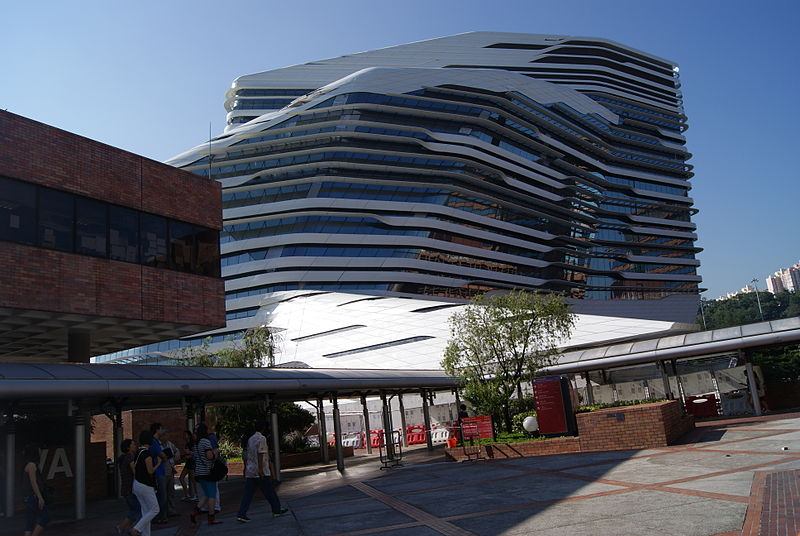

In [36]:
architecures_images = list(dataset_dir.glob('./*/*'))
PIL.Image.open(str(architecures_images[0]))

In [3]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


In [4]:
BATCH_SIZE_PER_REPLICA = 16 # 32
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync


img_height = 224 # 160
img_width = 224 # 160

IMG_SHAPE = (img_width, img_height, 3)

base_learning_rate = 0.0001

In [6]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.25,
    subset="both",
    seed=666,
    image_size=(img_height, img_width),
    batch_size=BATCH_SIZE
)

Found 4302 files belonging to 10 classes.
Using 3227 files for training.
Using 1075 files for validation.


In [7]:
class_names = train_ds.class_names
print(*class_names, sep=', ')

num_classes = len(class_names)
print("Number of classes:", num_classes)

ancient-egyptian, art-deco, art-nouveau, baroque, deconstructivism, gothic, greek-revival, international, romanesque, russian-revival
Number of classes: 10


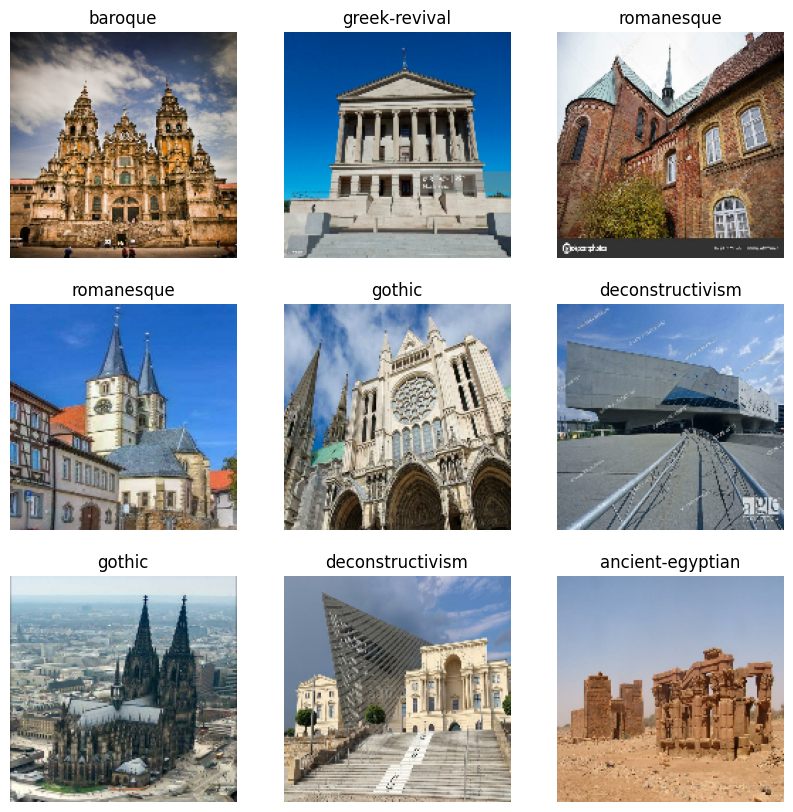

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.15)
])

## Custom function

In [10]:
def save_model(model, name):
    model.save(f"{name}.keras")

In [11]:
def model_prediction(model, img):
    # img = tf.keras.utils.load_img(
    # "1.jpg", target_size=(img_height, img_width)
    # )
    
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    print(predictions)
    
    score = tf.nn.softmax(predictions[0])
    print(score)
    
    print(f"Predicted value: {class_names[np.argmax(score)]}, probability {100 * np.max(score)}%")

In [104]:
def build_accuracy_plot(history, epochs, prefix=''):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(epochs)
    
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(2, 1, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.savefig(f'{prefix}accuracy_plot_{datetime.now().strftime("%Y-%m-%d-%H-%M")}.png', bbox_inches='tight')

    plt.show()

In [110]:
def get_metrics(model, prefix=''):
    y_true = []
    y_pred = []

    now = datetime.now().strftime("%Y-%m-%d-%H-%M")
    
    for images, labels in val_ds:
        predictions = model.predict(images, verbose=False)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(predictions, axis=1))
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8)) 
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_ds.class_names)
    disp.plot(cmap=plt.cm.Blues)
    
    plt.xticks(rotation=45, ha='right')  
    plt.title('Confusion Matrix')
    
    plt.savefig(f'{prefix}confusion_matrix_{now}.png', bbox_inches='tight')
    plt.show()
    
    test_loss, test_acc = model.evaluate(val_ds, verbose=False)
    
    data = {
       "test_accuracy": test_acc,
       "accuracy": accuracy_score(y_true, y_pred),
       "precision": precision_score(y_true, y_pred, average='macro'),
       "recall": recall_score(y_true, y_pred, average='macro'),
       "f1_score": f1_score(y_true, y_pred, average='macro'),
    }

    with open(f'{prefix}metrics_{now}.txt', 'w') as f:
        f.write(json.dumps(data))
        
    print('\n')
    print(*[f"{key.replace('_', ' ').capitalize()}: {value:.3f}" for key, value in data.items()], sep='\n')

# CNN

In [32]:
with strategy.scope():
    model = Sequential([
        layers.Input(shape=IMG_SHAPE),

        data_augmentation,
        layers.Rescaling(1./255),
        
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        
        layers.Flatten(),
        

        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.3),

        layers.Dense(124, activation='relu'),
        layers.Dropout(0.3),
        
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1024)           │   102,761,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 124)            │       127,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 124)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │         1,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,983,070 (392.85 MB)

 Trainable params: 102,983,070 (392.85 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
epochs = 100

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=30, restore_best_weights=True,)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[callback]
)

Epoch 1/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 19s 131ms/step - accuracy: 0.1298 - loss: 2.3305 - val_accuracy: 0.2435 - val_loss: 2.1713
Epoch 2/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 13s 123ms/step - accuracy: 0.2138 - loss: 2.1779 - val_accuracy: 0.2528 - val_loss: 2.0589
Epoch 3/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 0.2633 - loss: 2.0768 - val_accuracy: 0.2918 - val_loss: 1.9895
Epoch 4/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - accuracy: 0.2734 - loss: 2.0148 - val_accuracy: 0.3086 - val_loss: 1.8894
Epoch 5/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.3018 - loss: 1.9738 - val_accuracy: 0.2825 - val_loss: 1.9426
Epoch 6/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - accuracy: 0.2984 - loss: 1.9286 - val_accuracy: 0.3680 - val_loss: 1.7936
Epoch 7/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - accuracy: 0.3358 - loss: 1.8688 - val_accuracy: 0.3476 - val_loss: 1.8122
Epoch 8/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - accuracy: 0.3512 -

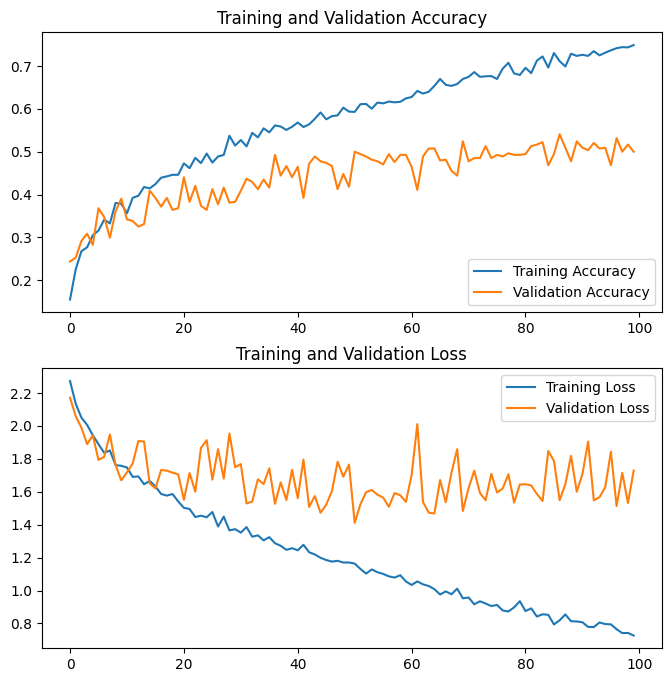

In [93]:
build_accuracy_plot(history, 100)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

<Figure size 1000x800 with 0 Axes>

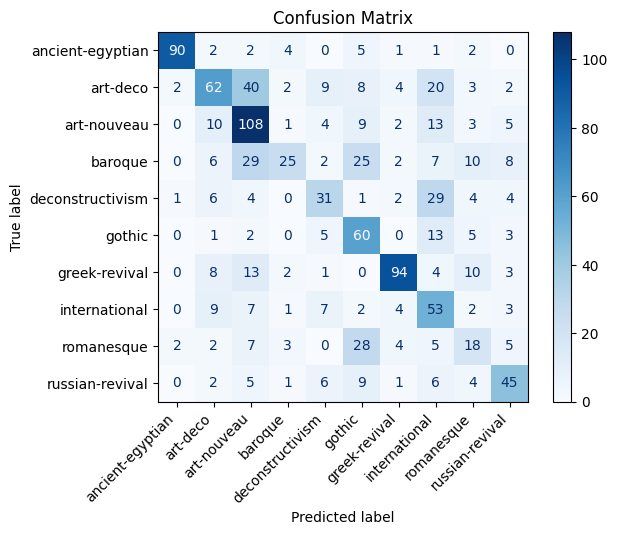

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.5450 - loss: 1.4833
Test accuracy: 0.541
Accuracy: 0.545
Precision: 0.559
Recall: 0.533
F1 score: 0.524


In [94]:
get_metrics(model)

In [95]:
save_model(model, 'cnn')

# Transfer Learning (MobileNetV2)

In [96]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [97]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

base_model.trainable = False
base_model.summary()

(32, 7, 7, 1280)


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [98]:
with strategy.scope():
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    feature_batch_average = global_average_layer(feature_batch)
    print(feature_batch_average.shape)
    
    prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax') 
    prediction_batch = prediction_layer(feature_batch_average)
    print(prediction_batch.shape)
    
    inputs = tf.keras.Input(shape=IMG_SHAPE)
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)

    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

(32, 1280)
(32, 10)


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [99]:
epochs = 100

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=30, restore_best_weights=True,)

history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                    callbacks=[callback])

Epoch 1/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 23s 113ms/step - accuracy: 0.1125 - loss: 2.7782 - val_accuracy: 0.2342 - val_loss: 2.1270
Epoch 2/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.1859 - loss: 2.2976 - val_accuracy: 0.3253 - val_loss: 1.8546
Epoch 3/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.2866 - loss: 1.9706 - val_accuracy: 0.3978 - val_loss: 1.6558
Epoch 4/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.3704 - loss: 1.7307 - val_accuracy: 0.4554 - val_loss: 1.5145
Epoch 5/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.4485 - loss: 1.5698 - val_accuracy: 0.4907 - val_loss: 1.4188
Epoch 6/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.4753 - loss: 1.4509 - val_accuracy: 0.5149 - val_loss: 1.3525
Epoch 7/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.5075 - loss: 1.3950 - val_accuracy: 0.5428 - val_loss: 1.2769
Epoch 8/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.5357 - loss: 1.3167 

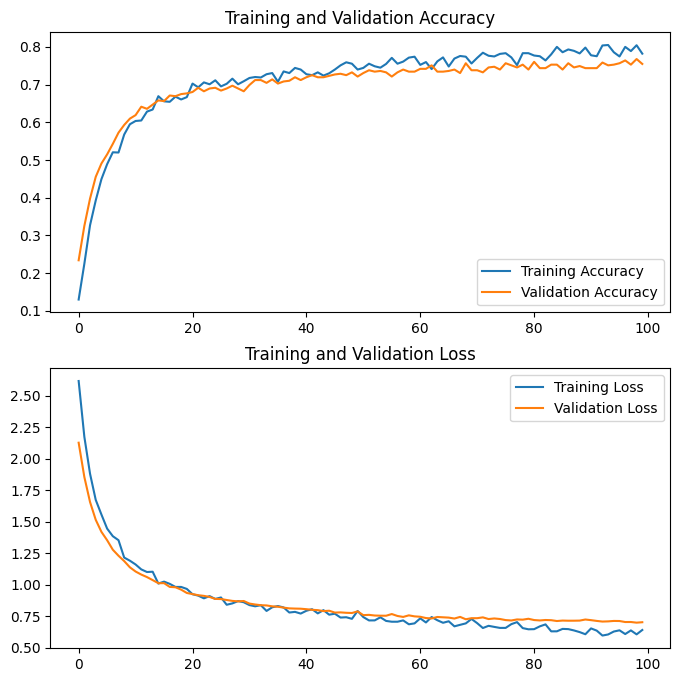

In [113]:
build_accuracy_plot(history, epochs, 'mobilenet_')

<Figure size 1000x800 with 0 Axes>

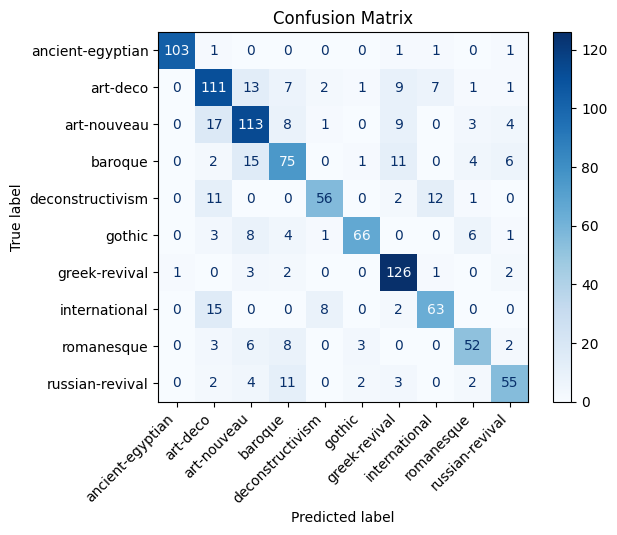



Test accuracy: 0.768
Accuracy: 0.763
Precision: 0.778
Recall: 0.755
F1 score: 0.764


In [114]:
get_metrics(model, 'mobilenet_')

In [102]:
save_model(model, 'mobilenet')

# VGG 19

In [25]:
base_model = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SHAPE,
    classifier_activation="softmax",
)

base_model.trainable = False

base_model.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [23]:
with strategy.scope():
    inputs = tf.keras.Input(shape=IMG_SHAPE)
    x = data_augmentation(inputs)
    x = base_model(inputs, training=False)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.4)(x)


    outputs = layers.Dense(num_classes)(x)
    model = tf.keras.Model(inputs, outputs)


    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,559,946 (78.43 MB)

 Trainable params: 535,562 (2.04 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [24]:
epochs = 50
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=15, restore_best_weights=True,)

history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                    callbacks=[callback])

Epoch 1/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 30s 239ms/step - accuracy: 0.1504 - loss: 8.8152 - val_accuracy: 0.3606 - val_loss: 5.6880
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 195ms/step - accuracy: 0.2821 - loss: 6.8692 - val_accuracy: 0.3625 - val_loss: 2.2866
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 193ms/step - accuracy: 0.2814 - loss: 2.8983 - val_accuracy: 0.3625 - val_loss: 2.3201
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 196ms/step - accuracy: 0.2709 - loss: 2.4272 - val_accuracy: 0.3699 - val_loss: 2.3026
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 193ms/step - accuracy: 0.2587 - loss: 2.3336 - val_accuracy: 0.3234 - val_loss: 2.3026
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 195ms/step - accuracy: 0.2485 - loss: 2.2975 - val_accuracy: 0.3104 - val_loss: 2.3026
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 195ms/step - accuracy: 0.2346 - loss: 2.3199 - val_accuracy: 0.2937 - val_loss: 2.3026
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 195ms/step - accuracy: 0.2474 - loss: 2

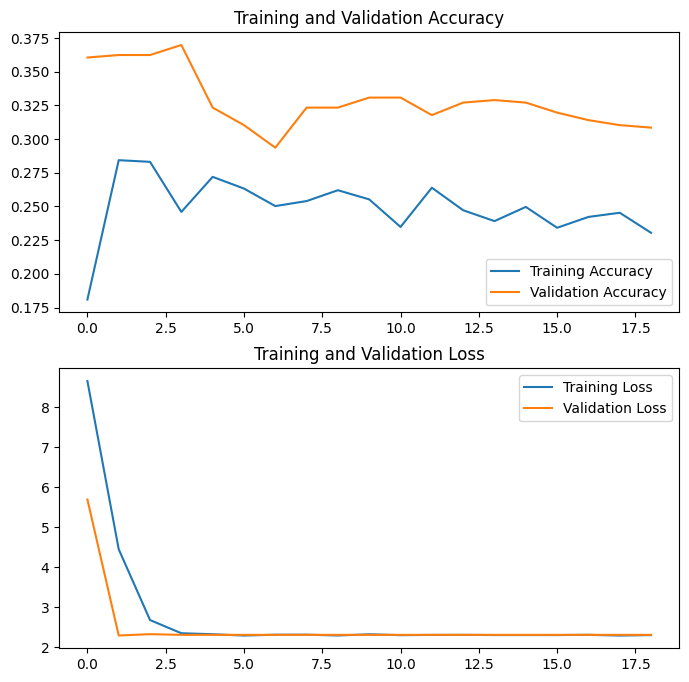

In [26]:
build_accuracy_plot(history, 19)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

<Figure size 1000x800 with 0 Axes>

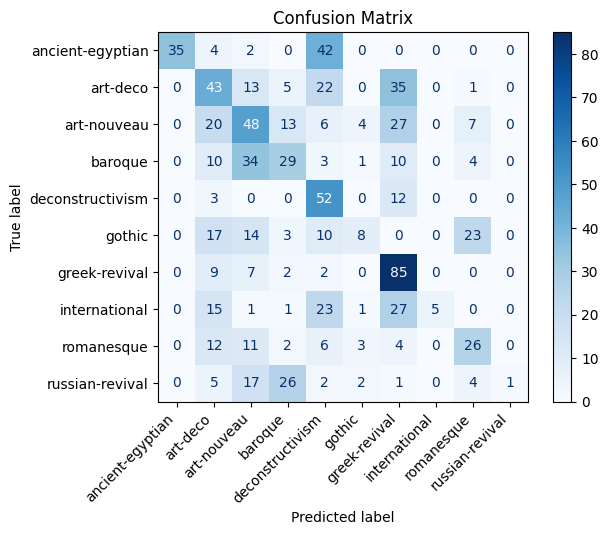

27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - accuracy: 0.4045 - loss: 2.2704
Test accuracy: 0.377
Accuracy: 0.386
Precision: 0.555
Recall: 0.367
F1 Score: 0.335


In [95]:
get_metrics(model)